In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from os import path

from tqdm import tqdm

import torch
from torch import nn
from torch.nn import functional as F
from torch.nn.functional import scaled_dot_product_attention
from torch.nn.attention import SDPBackend, sdpa_kernel
from torch.optim import AdamW, Adam
from torch import autocast, GradScaler

from omegaconf import OmegaConf, open_dict

torch.backends.cuda.matmul.allow_tf32 = True
torch.set_float32_matmul_precision('high')

In [2]:
# additional packages
# pip install hiera-transformer
# pip install -U pytorch_warmup

# Hyperparameters

In [3]:
video_size = [36, 64]
batchsize=16

screen_chunk_size = 30
screen_sampling_rate = 30

response_chunk_size = 8
response_sampling_rate = 8

behavior_as_channels = True
replace_nans_with_means = True

dim_head = 64
num_heads = 2
drop_path_rate = 0
mlp_ratio=4

### get dataloaders

In [4]:
paths = ['dynamic29513-3-5-Video-full',
         'dynamic29514-2-9-Video-full',
         'dynamic29755-2-8-Video-full',
         'dynamic29647-19-8-Video-full',
         'dynamic29156-11-10-Video-full',
         'dynamic29623-4-9-Video-full',
         'dynamic29515-10-12-Video-full',
         'dynamic29234-6-9-Video-full',
         'dynamic29712-5-9-Video-full',
         'dynamic29228-2-10-Video-full'
        ]

full_paths = [path.join("/data/mouse_polly/", f) for f in paths]

In [5]:
from experanto.dataloaders import get_multisession_dataloader
from experanto.configs import DEFAULT_CONFIG as cfg

In [6]:
cfg.dataset.global_chunk_size = None
cfg.dataset.global_sampling_rate = None

cfg.dataset.modality_config.screen.chunk_size = screen_chunk_size
cfg.dataset.modality_config.screen.sampling_rate = screen_sampling_rate
cfg.dataset.modality_config.eye_tracker.chunk_size = screen_chunk_size
cfg.dataset.modality_config.eye_tracker.sampling_rate = screen_sampling_rate
cfg.dataset.modality_config.treadmill.chunk_size = screen_chunk_size
cfg.dataset.modality_config.treadmill.sampling_rate = screen_sampling_rate

cfg.dataset.modality_config.responses.chunk_size = response_chunk_size
cfg.dataset.modality_config.responses.sampling_rate = response_sampling_rate

cfg.dataset.modality_config.screen.sample_stride = 1
cfg.dataset.modality_config.screen.include_blanks=True
cfg.dataset.modality_config.screen.valid_condition = {"tier": "train"}
cfg.dataset.modality_config.screen.transforms.Resize.size = video_size

cfg.dataloader.num_workers = 2
cfg.dataloader.prefetch_factor = 2
cfg.dataloader.batch_size = batchsize
cfg.dataloader.pin_memory = False
cfg.dataloader.shuffle = True

train_dl = get_multisession_dataloader(full_paths, cfg)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


### get Hiera backbone

In [30]:
# pip install hiera-transformer
from hiera import Hiera
tiny_hiera = Hiera(input_size=(screen_chunk_size, video_size[0], video_size[1]),
                     num_heads=1,
                     embed_dim=96,
                     stages=(2, 1,), # 3 transformer layers 
                     q_pool=1, 
                     in_chans=1,
                     q_stride=(1, 1, 1,),
                     mask_unit_size=(1, 8, 8),
                     patch_kernel=(5, 5, 5),
                     patch_stride=(3, 2, 2),
                     patch_padding=(1, 2, 2),
                     sep_pos_embed=True,
                     drop_path_rate=drop_path_rate,
                     mlp_ratio=4,)

tiny_hiera = tiny_hiera.cuda().to(torch.float32);
example_input = torch.ones(8,1,screen_chunk_size, 36,64).to("cuda", torch.float32)
out = tiny_hiera(example_input, return_intermediates=True);

hiera_output = out[-1][-1]
hiera_output.shape # (b, t, h, w, c): (8, 4, 9, 16, 192)

torch.Size([8, 10, 18, 32, 192])

# Model definition

In [31]:
class MouseHiera(nn.Module):
    def __init__(self,
                 backbone,
                 dls,
                 chunk_size,
                 dim=192,
                 dim_head=32,
                 num_heads=4,
                 mlp_ratio=4,):
        super().__init__()
        self.backbone=backbone
        self.num_heads=num_heads
        self.dim_head=dim_head
        self.dim=dim
        self.dim_q = dim_head*num_heads
        self.wq = nn.Linear(self.dim_q, self.dim_q, bias=False)
        self.wk = nn.Linear(dim, self.dim_q, bias=False)
        self.wv = nn.Linear(dim, self.dim_q, bias=False)
        self.wo = nn.Linear(self.dim_q, self.dim_q, bias=False)
        
        self.neuron_proj = nn.Linear(self.dim_q, chunk_size, bias=False)
        
        
        self.kv_norm=torch.nn.RMSNorm(dim)
        self.q_norm=torch.nn.RMSNorm(self.dim_q)
        self.qkv_norm=torch.nn.RMSNorm(self.dim_q)
        self.mlp = MLP(dim=self.dim_q, hidden_dim=int(self.dim_q * mlp_ratio))
        self.readout = nn.ModuleDict()
        self.activation = nn.Softplus(beta=0.1) # probably a much better activation than ELU+1
        for k, v in dls.loaders.items():
            n_neurons = next(iter(v))["responses"].shape[-1]
            self.readout[k] = IndexedLinearReadout(n_neurons, 
                                                   in_features=dim_head*num_heads,
                                                   dim_head=dim_head, 
                                                   num_heads=num_heads, 
                                                  )
        self.init_weights()

    def forward(self, x, key):
        x = self.backbone(x, return_intermediates=True)[-1][-1]
        b, t, h, w, d = x.shape
        x = self.kv_norm(x)
        x = x.view(b, -1, d) # (B, t*h*w, D)
        k, v = self.wk(x), self.wv(x)
        q = self.q_norm(self.readout[key].query) # (1, N, D)
        q = q.repeat(b, 1, 1) # repeat query for number of batches
        q_attn = self.wq(q)
        q_attn = q_attn.view(b, -1, self.num_heads, self.dim_head).transpose(1, 2)
        k = k.view(b, -1, self.num_heads, self.dim_head).transpose(1, 2) # (B, H, S, D)
        v = v.view(b, -1, self.num_heads, self.dim_head).transpose(1, 2) # (B, H, S, D)
        with sdpa_kernel(SDPBackend.FLASH_ATTENTION):
            o = F.scaled_dot_product_attention(q_attn, k, v)
        # (B, H, S, D) -> (B, N, D), with N = num_neurons
        o = o.transpose(1,2).contiguous().view(b, -1, self.dim_q)
        o = self.wo(o) + q
        o = self.qkv_norm(o)  
        o = self.mlp(o) + o
        o = self.neuron_proj(o) # (B, N, D) -> (B, N, t)
        o = o + self.readout[key].bias
        o = self.activation(o)
        return o
     
    def init_weights(self, std=.5, cutoff_factor: int = 3):
        """See `TorchTitan <https://github.com/pytorch/torchtitan/blob/40a10263c5b3468ffa53b3ac98d80c9267d68155/torchtitan/models/llama/model.py#L403>`__."""
        std = self.dim_q**-0.5
        for lin in (self.wq, self.wk, self.wv, self.wo):
            nn.init.trunc_normal_(
                lin.weight,
                mean=0.0,
                std=std,
                a=-cutoff_factor * std,
                b=cutoff_factor * std,
            )

In [32]:
class MLP(nn.Module):
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, dim),
        )
        self.init_weights()

    def forward(self, x):
        return self.net(x)
        
    def init_weights(self, std=.5, cutoff_factor: int = 3):
        """See `TorchTitan <https://github.com/pytorch/torchtitan/blob/40a10263c5b3468ffa53b3ac98d80c9267d68155/torchtitan/models/llama/model.py#L403>`__."""
        nn.init.trunc_normal_(
            self.net[0].weight,
            mean=0.0,
            std=std,
            a=-cutoff_factor * std,
            b=cutoff_factor * std,
        )
        nn.init.trunc_normal_(
            self.net[2].weight,
            mean=0.0,
            std=std,
            a=-cutoff_factor * std,
            b=cutoff_factor * std,
        )
        self.net[0].bias.data.zero_()
        self.net[2].bias.data.zero_()
        

In [33]:
class IndexedLinearReadout(nn.Module):
    """
    Readout module for MTM models with selectable weights based on 
    input IDs. Based on :class:`torch.nn.Linear`.
    """
    def __init__(
        self,
        unique_ids: int,
        in_features: int = 384,
        dim_head=32,
        num_heads=4,
        bias: bool = True,
        device="cuda",
        dtype=torch.float32,
        init_std: float = 0.02,
    ):
        super().__init__()
        factory_kwargs = {"device": device, "dtype": dtype}
        self.unique_ids = unique_ids
        self.in_features = in_features
        self.init_std = init_std
        self.query = nn.Parameter(
            torch.empty(1, unique_ids, dim_head*num_heads, **factory_kwargs)
        )
        if bias:
            self.bias = nn.Parameter(
                torch.empty(1, unique_ids, 1, **factory_kwargs)
            )
        else:
            self.register_parameter('bias', None)
        self.init_weights()

    def init_weights(self, cutoff_factor: int = 3):
        """See `TorchTitan <https://github.com/pytorch/torchtitan/blob/40a10263c5b3468ffa53b3ac98d80c9267d68155/torchtitan/models/llama/model.py#L403>`__."""
        readout_std = self.in_features**-0.5
        nn.init.trunc_normal_(
            self.query,
            mean=0.0,
            std=readout_std,
            a=-cutoff_factor * readout_std,
            b=cutoff_factor * readout_std,
        )
        if self.bias is not None:
            self.bias.data.zero_()

### Build Model

In [34]:
backbone_dim = hiera_output[-1][-1].shape[-1]
model = MouseHiera(backbone=tiny_hiera, 
                        dls=train_dl, 
                        chunk_size=response_chunk_size,
                        dim=backbone_dim, 
                        dim_head=dim_head,
                        num_heads=num_heads,
                       mlp_ratio=mlp_ratio)
model = model.to(torch.float32).cuda();

# Trainer

In [35]:
# pip install -U pytorch_warmup
import pytorch_warmup as warmup

n_epochs = 1
lr = 2e-4
gradient_clipping = 1.0
criteria = nn.PoissonNLLLoss(log_input=False, reduction='mean')
opt = AdamW(model.parameters(), lr=lr)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt,
                                                          T_max=1e6, 
                                                          eta_min=1e-5)
warmup_scheduler = warmup.UntunedLinearWarmup(opt)

# Logging

In [49]:
import os
import sys
from omegaconf import DictConfig, ListConfig

import hydra
from hydra import utils
import mlflow
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split
import mlflow
mlflow.set_tracking_uri("http://at-compute015:5000/")
experiment_name = "mousehiera-base-0"
current_experiment=dict(mlflow.get_experiment_by_name(experiment_name))
experiment_id=current_experiment['experiment_id']

# train

In [53]:
n_epochs = 8

with mlflow.start_run(
    run_name="sota_no_behavior",
    experiment_id=experiment_id,
    tags={"version": "v1", "priority": "P1"},
    description="parent",):
    for _ in range(n_epochs):
        for i, (key, batch) in tqdm(enumerate(train_dl)):
            videos = batch["screen"].to("cuda", torch.float32, non_blocking=True).transpose(1,2)
            responses = batch["responses"].to("cuda", torch.float32, non_blocking=True)
            with autocast(device_type='cuda', dtype=torch.bfloat16):
                out = model(videos, key);
            loss = criteria(out.transpose(1,2), responses)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=gradient_clipping, norm_type=2)
            opt.step()
            opt.zero_grad()
            with warmup_scheduler.dampening():
                lr_scheduler.step()
            
            if i % 100 == 0:
                mlflow.log_metric("train/loss", loss.item())
            if i % 10000 == 0:
                val_corr = val_step()
                test_corr = test_step()
                mlflow.log_metric("validation/correlation", val_corr)
                mlflow.log_metric("test/correlation", test_corr)

0it [00:00, ?it/s]
2024/11/16 13:45:00 INFO mlflow.tracking._tracking_service.client: 🏃 View run sota_no_behavior at: http://at-compute015:5000/#/experiments/226994315416355842/runs/5d484dc0d8b345a69f786d9b2e3bb737.
2024/11/16 13:45:00 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://at-compute015:5000/#/experiments/226994315416355842.


RuntimeError: DataLoader worker (pid(s) 42706, 42769) exited unexpectedly

# Validation dataloader

In [42]:
cfg.dataset.modality_config.screen.sample_stride = screen_chunk_size
cfg.dataset.modality_config.screen.include_blanks=False
cfg.dataset.modality_config.screen.valid_condition = {"tier": "oracle"}

# example session
val_dl = get_multisession_dataloader(full_paths[0:1], cfg)

_, b = next(iter(val_dl))
n_neurons = b["responses"].shape[-1]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [43]:
def val_step():
    from torchmetrics.regression import PearsonCorrCoef
    r = PearsonCorrCoef(num_outputs=n_neurons).cuda()
    with torch.no_grad():
        for i, (k, b) in tqdm(enumerate(val_dl)):
            videos = b["screen"].to("cuda", torch.float32, non_blocking=True).permute(0,2,1,3,4)
            responses = b["responses"].to("cuda", torch.float32, non_blocking=True)
            with autocast(device_type='cuda', dtype=torch.bfloat16):
                out = model(videos, k);
            r.update(out.transpose(1,2).reshape(-1, n_neurons), responses.reshape(-1, n_neurons))
    return r.compute().cpu().numpy().mean()

In [44]:
val_step()

33it [00:04,  7.48it/s]


np.float32(0.0048931735)

# Final Test Set Score

In [57]:
cfg.dataset.modality_config.screen.sample_stride = screen_chunk_size
cfg.dataset.modality_config.screen.include_blanks=False
cfg.dataset.modality_config.screen.valid_condition = {"tier": "final_test_1"}

# example session
val_dl = get_multisession_dataloader(full_paths[7:8], cfg)

_, b = next(iter(val_dl))
n_neurons = b["responses"].shape[-1]

In [58]:
def test_step():
    from torchmetrics.regression import PearsonCorrCoef
    r = PearsonCorrCoef(num_outputs=n_neurons).cuda()
    with torch.no_grad():
        for i, (k, b) in tqdm(enumerate(val_dl)):
            videos = b["screen"].to("cuda", torch.float32, non_blocking=True).permute(0,2,1,3,4)
            responses = b["responses"].to("cuda", torch.float32, non_blocking=True)
            with autocast(device_type='cuda', dtype=torch.bfloat16):
                out = model(videos, k);
            r.update(out.transpose(1,2).reshape(-1, n_neurons), responses.reshape(-1, n_neurons))
    return r.compute().cpu().numpy().mean()

In [56]:
#0
test_step()

34it [00:05,  6.42it/s]


np.float32(0.18565184)

In [59]:
#7
test_step()

33it [00:05,  6.01it/s]


np.float32(0.18863237)

In [69]:
full_responses = np.array(val_dl.loaders["29234-6-9"].dataset._experiment.devices["responses"]._data)

In [97]:
neuron_stds = full_responses.mean(0)

(array([6.054e+03, 1.648e+03, 4.090e+02, 1.140e+02, 3.500e+01, 1.400e+01,
        4.000e+00, 2.000e+00, 1.000e+00, 4.000e+00]),
 array([ 0.38846614,  3.92644211,  7.46441807, 11.00239404, 14.54037   ,
        18.07834597, 21.61632193, 25.15429789, 28.69227386, 32.23024982,
        35.76822579]),
 <BarContainer object of 10 artists>)

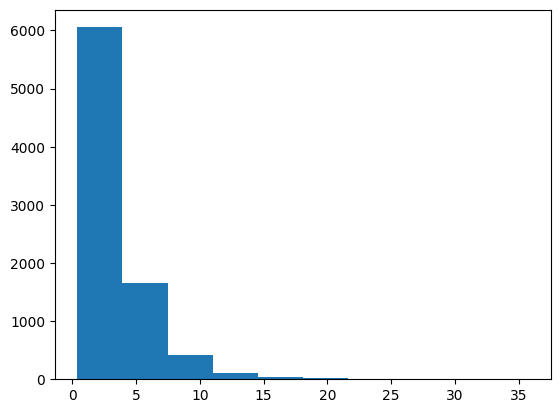

In [98]:
plt.hist(neuron_stds)

In [76]:
import os

In [77]:
os.getcwd()

'/src/hiera'

In [80]:
r_folder = "/src/data/static26872-17-20-GrayImageNet-94c6ff995dac583098847cfecd43e7b6/data/responses/"

In [82]:
files = os.listdir(r_folder)

In [90]:
rs = []
for f in files:
    rs.append(np.load(r_folder+f))

(array([6.924e+03, 7.000e+02, 9.900e+01, 2.700e+01, 1.100e+01, 4.000e+00,
        6.000e+00, 1.000e+00, 0.000e+00, 4.000e+00]),
 array([ 0.06870206,  6.1389308 , 12.2091589 , 18.27938843, 24.349617  ,
        30.41984558, 36.49007416, 42.56030273, 48.63053131, 54.70075989,
        60.77098846]),
 <BarContainer object of 10 artists>)

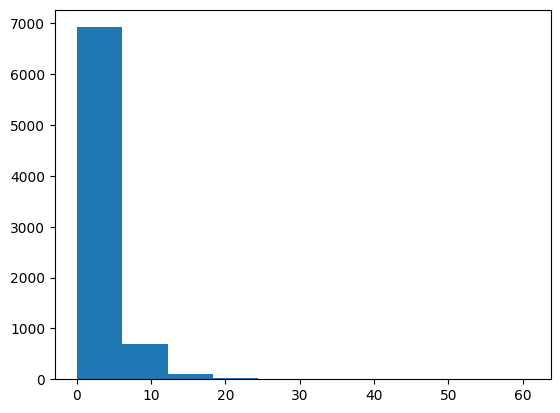

In [96]:
plt.hist(np.stack(rs).mean(0))

In [94]:
np.stack(rs).max(0)

array([ 68.17766 ,  71.031075,  86.44531 , ..., 128.21367 , 203.41245 ,
       254.2348  ], dtype=float32)